<a href="https://colab.research.google.com/github/CianOSull/AutoML_With_SA_FYP_2021/blob/AutoKeras/MainNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generic Notebook for running all the libraries

How this notebook works is that it contains the code
for loading and cleaning the dataset.

Then there is multiple branches created on the
Github that include the code for running each library.

E.g. MLBox branch has the code for running MLBox.

# CURRENT BRANCH = AUTOKERAS

# Install the necessary library
Run the install code in the code cell below.

In [17]:
# Insert any install comamnds in this cell
!pip3 install autokeras

# Preprocessing Section

In [3]:
# Import the necessary modules for cleaning
import math
import time 
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [4]:
# Create the set of stopwords for cleaning text
stopwords = set(w.rstrip() for w in open('/content/drive/MyDrive/CIT/FYP/ImplementationFiles/stopwords.txt'))

In [5]:
# Download the necessary parts for the NLTK module
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
# This funciton handles celaning text
def clean_text(text):
    # Create the lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # Get rid of non alpha characters except "'" as it is needed for the lemment
    text = "".join(c for c in text if c.isalnum() or c == " " or "'")
    
    # Get rid of capitals
    text = text.lower()
    
    # Tokenize the words    
    # Create tokens of each word
    token_text = word_tokenize(text)
    
    # Get rid of any piece of text that isn't over 2 characters
    token_text = [t for t in token_text if len(t) > 2] 
    
    # Put words in base form by doing lemmatization
    token_text = [wordnet_lemmatizer.lemmatize(t) for t in token_text]

    # Remove stopwords
    token_text = [t for t in token_text if t not in stopwords]
    
    # Return the tokens
    return token_text

In [7]:
# This function will get the term frequencies for word in the review
# TF = Term I frequency in document/total words in document
def calc_tf(term_count, review_corpus):
    # A dictionary of all the term frequencies found
    tf_freq = dict.fromkeys(term_count.keys(), 0)   
    
    # Review corpus is a tokenized list so the total words iteh length
    total_words = len(review_corpus)
    
    # Calculate the term frequency for each word
    for word, count in term_count.items():
        tf_freq[word] = count/total_words
        
    return tf_freq

In [8]:
# This calcualtes the idf
# IDF = log(2)*(Total number of Documents/documents frequency or documents with term)
def calc_idf(unique_terms, list_doc_terms):   
    # A dicitonary of all the inverse document frequencies
    idf = dict.fromkeys(unique_terms, 0)
    
    # Basically list_doc_terms has all the documents with the term count for each word
    # You go through each document count the terms where they occured
    for doc_terms in list_doc_terms:  
        # This for loop is counting the amount of document a word was in
        for word, value in doc_terms.items():
            if 0 < value:
                idf[word] += 1
        
    # Now we calculate idf
    for word, value in idf.items():
        idf[word] = math.log10(10 / float(value))
    
    return idf

In [9]:
# Modified this function to return a list as dictionaries arn't needed anymore
def calc_tf_idf(tf, idf, n_terms):
    # Create an array that is of length of the number of unique terms
    tf_idf_array = np.zeros(n_terms)
    
    for index, (word, value) in enumerate(tf.items()):
        # Add the tfidf to the array
        tf_idf_array[index] = value*idf[word]
    
    return tf_idf_array

In [10]:
def process_text(text_data):
    # A list of all the cleaned reviews
    doc_list = []
    
    # List of all the unique terms
    unique_terms = []
    
    # A list of all the term frequencies
    tf_list = []
    
    for review in text_data:
        # First clean the review
        clean_review = clean_text(review)
        
        # Keeps track of the term counts for each word
        count_dict = {}
        
        # Now lets find the total count for each word
        for token in clean_review:
            if token not in count_dict:
                count_dict[token] = 1
            else:
                count_dict[token] += 1
        
        # Caclulate the term frequencies for each document
        tf_list.append(calc_tf(count_dict, clean_review))
        
        # Then add the dictionary of counts for each document to the list
        doc_list.append(count_dict)
        
        # Then add the new unique terms
        unique_terms = set(unique_terms).union(set(clean_review))
    
    # Calculate the inverse document frequency value
    idf = calc_idf(unique_terms, doc_list)
    
    # This array will contain the tfidf values for each term in each review
    tfidf_values = np.zeros((len(tf_list), len(unique_terms)))
    
    # Now we can get the TFIDF for each document
    for index, term_freq in enumerate(tf_list):
        # This will return an array of the tfidf values calculated.
        # The length of the unique terms list is passed in so that the 
        # Array that is returned matches the tfidf array
        tf_idf_array = calc_tf_idf(term_freq, idf, len(unique_terms))
        # Add this to the overall tfidf values calculated
        tfidf_values[index,:] = tf_idf_array
    
    return tfidf_values

In [11]:
# Prepare the data
def prepare_data():
    print("="*50)

    # Load the dataset
    # imdb_df = pd.read_csv("IMDB Dataset.csv")
    imdb_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/IMDB_Dataset.csv")
    print("Dataset loaded")
    print("="*50)

    
    # Change each positive and negative value to 1 and 0 respectively    
    imdb_df['sentiment'] = imdb_df['sentiment'].map({'negative' : 0, 'positive' : 1})
    
    # For testing, a much smaller dataset is going to be used
    imdb_df = imdb_df.head(5000)

    # Group all the negative reviews and get the first 2500
    imdb_df_neg = (imdb_df[imdb_df['sentiment'] == 0])[0:2500]
    # Group all the positive and get the first 2500
    imdb_df_pos = imdb_df[imdb_df['sentiment'] == 1]
    
    test_df = pd.concat([imdb_df_neg, imdb_df_pos]) 
    # print(test_df)
    
    # .values on a column of a dataframe returns a numpy array
    # This is a numpy array of all the reviews
    # initial_reviews = imdb_df['review'].values
    initial_reviews = test_df['review'].values
    
    # This is a numpy array of all the positive and negativelabels
    # labels = imdb_df['sentiment'].values
    labels = test_df['sentiment'].values
    
    print("Creating Feature Vector")
    print("="*50)
    start = time.time()
    # Process the text data and create teh feature vector
    feature_vector = process_text(initial_reviews)
    end = time.time()
    print("Feature Vector Created")
    print(f"Execution time is {end - start} secs")
    print("="*50)
    
    # Shuffle the labesl and feature vector using sklearn shuffle
    feature_vector, labels = shuffle(feature_vector, labels)
    
    # Creating train and test data
    # The splits will be 80:20 
    no_samples = 0.8
    
    # This gets the percentage of indexes from feature vector and uses those for training
    X_train = feature_vector[0:int(no_samples*len(feature_vector))]
    y_train = labels[0:int(no_samples*len(labels))]
    
    # Go from the index that was used for training to the final
    X_test = feature_vector[int(no_samples*len(feature_vector)):len(feature_vector)]
    y_test = labels[int(no_samples*len(labels)):len(labels)]

    return X_train, y_train, X_test, y_test

# Create Model Section 

**Exporting models:**

https://autokeras.com/tutorial/export/

Auto Keras has a built in text classifier that takes in strings so going to test using that?



Look into checking the validation accuracy in autokeras
Early stopping based on the accuracy and loss for the validation to stop once it platous
Validation shows when training is not learning anymore


In [19]:
import autokeras as ak

In [20]:
# Load the dataset
imdb_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/IMDB_Dataset.csv")
# print(imdb_df.head())

# For testing, a much smaller dataset is going to be used
# imdb_df = imdb_df.head(4000)
# print(imdb_df.head())

imdb_df['sentiment'] = imdb_df['sentiment'].map({'negative' : 0, 'positive' : 1})

# Group all the negative reviews and get the first 25000
# imdb_df_neg = (imdb_df[imdb_df['sentiment'] == "negative"])[0:2500]
imdb_df_neg = (imdb_df[imdb_df['sentiment'] == 0])[0:500]
# Group all the positive and get the first 25000
# imdb_df_pos = imdb_df[imdb_df['sentiment'] == "positive"][0:2500]
imdb_df_pos = imdb_df[imdb_df['sentiment'] == 1][0:500]

# Combine the two split positives and negatives into one dataframe
imdb_df = pd.concat([imdb_df_neg, imdb_df_pos]) 

# .values on a column of a dataframe returns a numpy array
# This is a numpy array of all the reviews
# initial_reviews = imdb_df['review'].values
feature_vector = imdb_df['review'].values
# print(feature_vector)

# This is a numpy array of all the positive and negativelabels
labels = imdb_df['sentiment'].values

# Shuffle the labesl and feature vector using sklearn shuffle
feature_vector, labels = shuffle(feature_vector, labels)

# Creating train and test data
# The splits will be 80:20 
no_samples = 0.8

# This gets the percentage of indexes from feature vector and uses those for training
X_train = feature_vector[0:int(no_samples*len(feature_vector))]
y_train = labels[0:int(no_samples*len(labels))]

# Go from the index that was used for training to the final
X_test = feature_vector[int(no_samples*len(feature_vector)):len(feature_vector)]
y_test = labels[int(no_samples*len(labels)):len(labels)]

print(X_train.shape)
print(type(X_train))

(800,)
<class 'numpy.ndarray'>


In [21]:
# Create the text classifier
# It is only going to do 1 model but change max trials for more
# Has a built in project name, default is text_classifier
# Trials is the amount of keras models to use, default is 1000 and might stop before reaching that number
# Directory sets where search outputs will be saved
# Objective is what it needs to prioritise, default is val_loss but val_accuracy can be used
# Naming convention = ak_epochs_dataNo_trials
clf = ak.TextClassifier(overwrite=True, project_name="ak_10_5000_2", max_trials=2, directory="/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/AutoKeras/SearchOuputs", objective="val_loss")

In [22]:
# Call the fit function and train the models for only 2 epochs
# Leave empty for adaptive epochs
# By default, auto keras will use the last 20% of training data for validation
# Setting validation to 0.2 in this case to just to demonstrate
print("Creating Fit the model")
print("="*50)
start = time.time()
# Default epochs is 1000
clf.fit(X_train, y_train, validation_split=0.2, epochs=10, verbose=1)
end = time.time()
print("Model Fitting Finished")
print(f"Execution time is {end - start} secs")
print("="*50)

Trial 2 Complete [00h 00m 26s]
val_loss: 0.5219522714614868

Best val_loss So Far: 0.503497302532196
Total elapsed time: 00h 01m 16s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
25/25 [==============================] - 6s 215ms/step - loss: 0.6970 - accuracy: 0.4839
Epoch 2/10
25/25 [==============================] - 5s 215ms/step - loss: 0.6999 - accuracy: 0.4786
Epoch 3/10
25/25 [==============================] - 5s 216ms/step - loss: 0.6868 - accuracy: 0.5611
Epoch 4/10
25/25 [==============================] - 5s 218ms/step - loss: 0.6789 - accuracy: 0.5735
Epoch 5/10
25/25 [==============================] - 5s 217ms/step - loss: 0.6418 - accuracy: 0.7013
Epoch 6/10
25/25 [==============================] - 6s 222ms/step - loss: 0.5697 - accuracy: 0.6979
Epoch 7/10
25/25 [==============================] - 6s 231ms/step - loss: 0.4571 - accuracy: 0.7983
Epoch 8/10
25/25 [==============================] - 6s 222ms/step - loss: 0.2552 - accuracy: 0.9066
Epoch 9/10
25/25 [===========

In [17]:
# Create some predictions
predicted_y = clf.predict(X_test)

# Evaluate the model used
print(clf.evaluate(X_test, y_test, verbose = 1))

7/7 [==============================] - 1s 48ms/step - loss: 0.5474 - accuracy: 0.7700
[0.5473529696464539, 0.7699999809265137]


# Metrics

In [40]:
from sklearn import metrics

# paramters are y_true, y_pred
C = metrics.confusion_matrix(y_test, predicted_y)

# lists for the confusion matrix
true_positive = []
true_negative = []
false_postiive = []
false_negatives = []

true_positive.append(C[0,0])
true_negative.append(C[1,1])            
false_postiive.append(C[1,0])
false_negatives.append(C[0,1])

print(C)

print(("="*50))

print("True positives:", round(np.sum(true_positive)/len(y_test), 5), "%")
print("True negatives:", round(np.sum(true_negative)/len(y_test), 5), "%")
print("False positives:", round(np.sum(false_postiive)/len(y_test), 5), "%")
print("False negatives:", round(np.sum(false_negatives)/len(y_test), 5), "%")

[[73 28]
 [18 81]]
True positives: 0.365 %
True negatives: 0.405 %
False positives: 0.09 %
False negatives: 0.14 %


In [46]:
true_positive = C[0,0]
true_negative = C[1,1]            
false_postiive = C[1,0]
false_negatives = C[0,1]

precision = true_positive/(true_positive+false_postiive)
recall = true_positive/(true_positive/false_negatives)

In [47]:
f1_score = (precision*recall)/(precision+recall)

print(f1_score)

0.7798550171690195


In [48]:
FPR = false_postiive/(false_postiive+true_negative)
print(FPR)

0.18181818181818182


In [42]:
fpr, tpr, thresh = metrics.roc_curve(y_test, predicted_y)

auc = metrics.auc(fpr, tpr)

print("AUC:", auc)

AUC: 0.7704770477047705


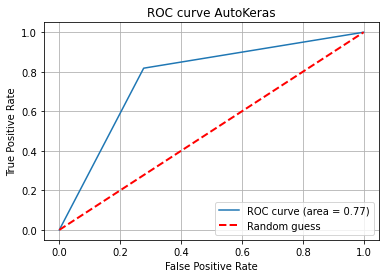

In [49]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve AutoKeras')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [18]:
best_model = clf.export_model()

# Naming convenction = ModelAutoKeras_epochs_dataNo_trials
try:
    best_model.save("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/AutoKeras/Models/mak_10_5000_2", save_format="tf")
except:
    best_model.save("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/AutoKeras/Models/mak_10_5000_2.h5")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/AutoKeras/Models/mak_10_5000_2/assets


In [ ]:
# Test loading a model
import tensorflow as tf
import tensorflow.keras

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/AutoKeras/Models/mak_100_5000_2", custom_objects=ak.CUSTOM_OBJECTS)

In [ ]:
predicted_y = loaded_model.predict(tf.expand_dims(X_test, -1))
# print(predicted_y)
print(loaded_model.evaluate(X_test, y_test, verbose = 1))

32/32 [==============================] - 2s 60ms/step - loss: 0.1744 - accuracy: 0.9670
[0.17436569929122925, 0.9670000076293945]


# Test on test dataset

In [ ]:
# Load the dataset
imdb_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/NPS_TestContent.csv", encoding='utf8', engine='c')
# imdb_df = pd.read_excel("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/NPS_TestContent.xlsx")

print(imdb_df.head(10))
print(imdb_df.columns)

                                                test sentiment
0                               Normal use is light.  Positive
1                                   I use it myself.  Positive
2                         There's no way to compare.  Positive
3                  Each person has his or her taste.  Positive
4               I think there's a sense of security.  Positive
5  Because I use it from the introduction of a pr...  Positive
6  I've been using it for 20 years and I've never...  Positive
7                        I'm using it in my company.  Positive
8  It is a reliable security software. However, b...  Positive
9  There are a lot of updates and additional noti...  Negative
Index(['test', 'sentiment'], dtype='object')


In [ ]:
# Load the dataset
imdb_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/NPS_TestContent.csv", encoding='utf8', engine='c')
# imdb_df = pd.read_excel("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/NPS_TestContent.xlsx")

imdb_df['sentiment'] = imdb_df['sentiment'].map({'Negative' : 0, 'Positive' : 1})

# Group all the negative reviews and get the first 25000
# imdb_df_neg = (imdb_df[imdb_df['sentiment'] == "negative"])[0:2500]
imdb_df_neg = (imdb_df[imdb_df['sentiment'] == 0])
# Group all the positive and get the first 25000
# imdb_df_pos = imdb_df[imdb_df['sentiment'] == "positive"][0:2500]
imdb_df_pos = imdb_df[imdb_df['sentiment'] == 1]

# Combine the two split positives and negatives into one dataframe
imdb_df = pd.concat([imdb_df_neg, imdb_df_pos]) 

# .values on a column of a dataframe returns a numpy array
# This is a numpy array of all the reviews
# initial_reviews = imdb_df['review'].values
feature_vector = imdb_df['test'].values
# print(feature_vector)

# This is a numpy array of all the positive and negativelabels
labels = imdb_df['sentiment'].values

# Shuffle the labesl and feature vector using sklearn shuffle
feature_vector, labels = shuffle(feature_vector, labels)

# Creating train and test data
# The splits will be 80:20 
no_samples = 0.8

# This gets the percentage of indexes from feature vector and uses those for training
X_train = feature_vector[0:int(no_samples*len(feature_vector))]
y_train = labels[0:int(no_samples*len(labels))]

# Go from the index that was used for training to the final
X_test = feature_vector[int(no_samples*len(feature_vector)):len(feature_vector)]
y_test = labels[int(no_samples*len(labels)):len(labels)]

print(X_train.shape)
print(type(X_train))

(1198,)
<class 'numpy.ndarray'>


In [ ]:
predicted_y = loaded_model.predict(tf.expand_dims(X_test, -1))
# print(predicted_y)
print(loaded_model.evaluate(X_test, y_test, verbose = 1))

10/10 [==============================] - 1s 56ms/step - loss: 1.2689 - accuracy: 0.4467
[1.2688533067703247, 0.4466666579246521]
